# MIMIC-III database

Analyzing PATIENTS, ADMISSIONS and DIAGNOSES_ICD tables.

Obs.: CAREGIVERS are linked with CHARTEVENTS table through CGID.


In [0]:
# Imports
from IPython.display import Image
import pandas as pd
import numpy as np
from scipy.stats import binom_test

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager
import seaborn as sns

# Colab
import io

%matplotlib inline

In [0]:
# READ CSV - Method 2 (Drive)
from google.colab import drive
drive.mount('/content/drive')

### PLOT CONFIG

In [0]:
plt.style.use('ggplot')

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=11

### MIMIC-III SCHEMA

ER-Diagram: https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/data_viz/01_data_viz_basic.ipynb


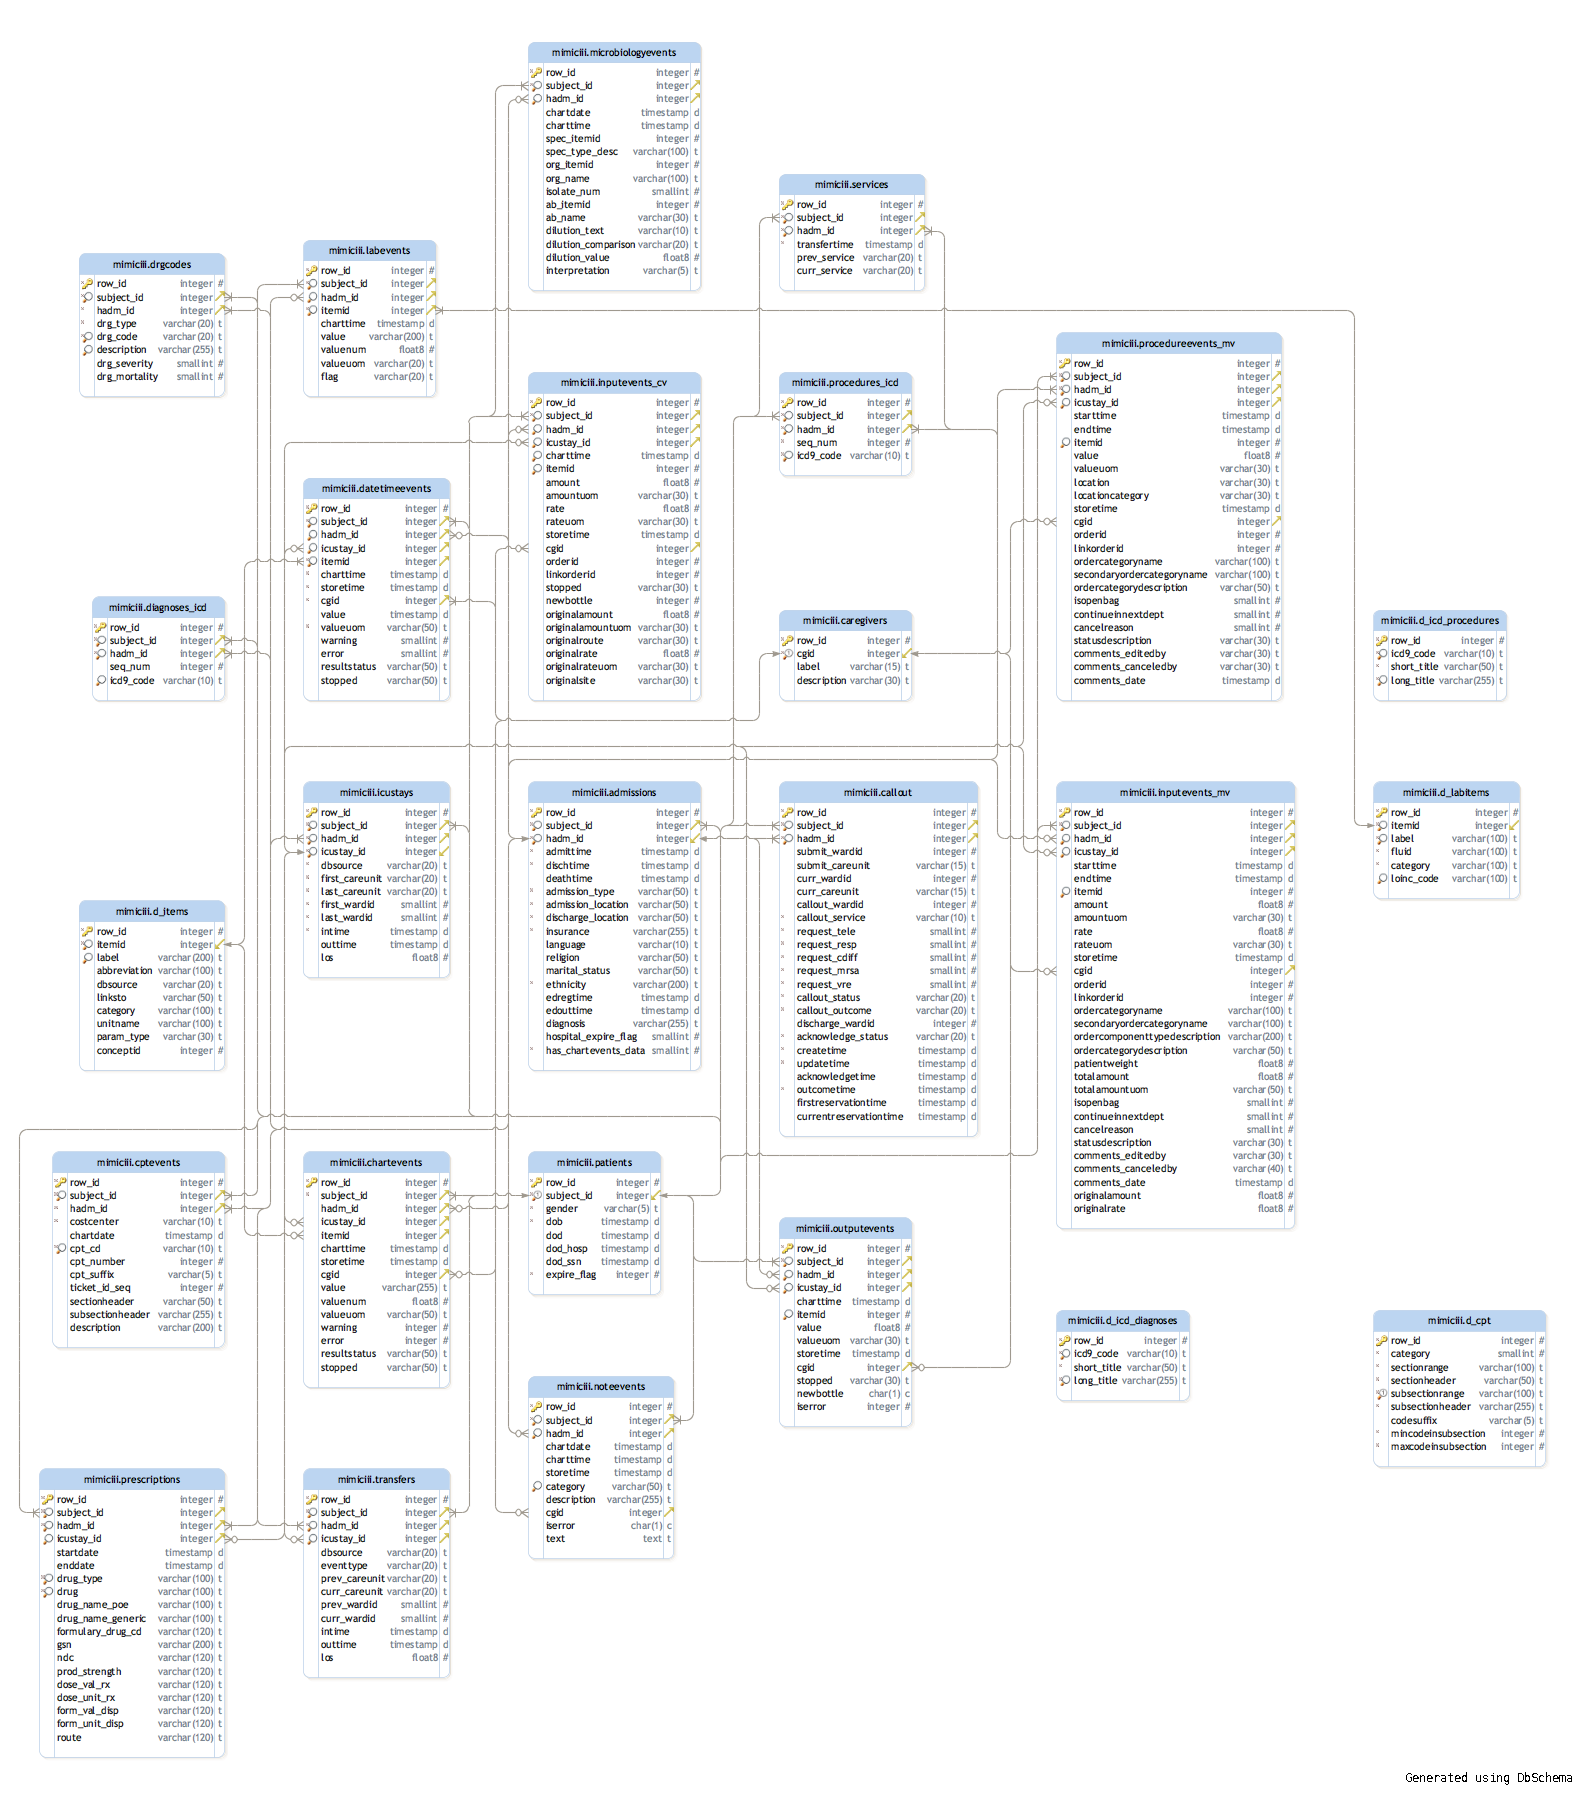

In [0]:
Image(filename = "/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/img/er_mimic.png", width=1000, height=1000)

### 1. PATIENTS TABLE


In [0]:
# Drive path
mimic_patients_df = pd.read_csv('/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/mimic-III/PATIENTS.csv')
mimic_patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [0]:
# Total patients
print("Total patients: " + str(mimic_patients_df.GENDER.count()))

# Total from each gender
mimic_patients_df.GENDER.value_counts()

Total patients: 46520


M    26121
F    20399
Name: GENDER, dtype: int64

In [0]:
# Pizza plot: just as an example

# patients_by_gender = mimic_patients_df.groupby(['GENDER']).count()['ROW_ID'].plot(kind='pie', autopct='%1.0f%%', 
#                                                                                   shadow=False, startangle=0, pctdistance=1.2, 
#                                                                                   labeldistance=1.4)
# patients_by_gender.axis('equal')
# patients_by_gender.legend(bbox_to_anchor=(1.0, 0.8))

#### Plot function

In [0]:
def countplot_frequency(df, column_name, title, order=None):
  ax = sns.countplot(x=column_name, data=df, order=order)
  plt.title(title)

  # Make twin axis
  ax2=ax.twinx()

  # Switch so count axis is on right, frequency on left
  ax2.yaxis.tick_left()
  ax.yaxis.tick_right()

  # Also switch the labels over
  ax.yaxis.set_label_position('right')
  ax2.yaxis.set_label_position('left')

  ax2.set_ylabel('Frequency [%]')

  ncount = len(df)
  for p in ax.patches:
      x=p.get_bbox().get_points()[:,0]
      y=p.get_bbox().get_points()[1,1]
      ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

  # Use a LinearLocator to ensure the correct number of ticks
  ax.yaxis.set_major_locator(mtick.LinearLocator(11))

  # Fix the frequency range to 0-100
  ax2.set_ylim(0,100)
  ax.set_ylim(0,ncount)

  # And use a MultipleLocator to ensure a tick spacing of 10
  ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))

  # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
  ax2.grid(None)
  return ax

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


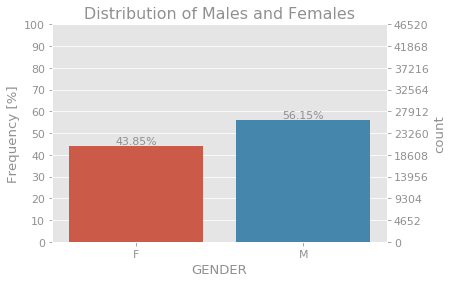

In [0]:
# Gender distribution
countplot_frequency(mimic_patients_df, 'GENDER', 'Distribution of Males and Females')

### 2. ADMISSIONS TABLE

In [0]:
# Drive path
mimic_admission_df = pd.read_csv('/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/mimic-III/ADMISSIONS.csv')
mimic_admission_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


#### Some general infos

In [0]:
# Total admissions
mimic_admission_df.count()

In [0]:
# Type
mimic_admission_df.ADMISSION_TYPE.value_counts()

In [0]:
# Admission Location
mimic_admission_df.ADMISSION_LOCATION.value_counts()

In [0]:
# Discharge Location
mimic_admission_df.DISCHARGE_LOCATION.value_counts()

#### MERGE: PATIENTS AND ADMSSIONS TABLE

In [0]:
ap = pd.merge(mimic_admission_df, mimic_patients_df, on = 'SUBJECT_ID' , how = 'inner')

#### AGE CALCULATION

In [0]:
ages_df = ap

# ADMITTIME and DOB objects to datetime
ages_df["ADMITTIME"] = pd.to_datetime(ages_df["ADMITTIME"], format='%Y%m%d %H:%M:%S')
ages_df["DOB"] = pd.to_datetime(ages_df["DOB"], format='%Y%m%d %H:%M:%S')

In [0]:
ages_df["AGES"] = ages_df["ADMITTIME"].sub(ages_df["DOB"]).dt.days/365.242

# Adult patients only
ages_df = ages_df[(ages_df.AGES >= 18)]
ages_df.SUBJECT_ID.nunique()

36560

### GENDER

In [0]:
# From each gender
patients_by_gender = ages_df.groupby('GENDER')['SUBJECT_ID'].nunique()
patients_by_gender

In [0]:
# Gender distribution: only adults
countplot_frequency(ages_df, 'GENDER', 'Adults patients only')

In [0]:
# Median age: total patients (non-unique)
ages_df['AGES'].mean()

In [0]:
# Standard deviation
ages_df['AGES'].std()

In [0]:
# Median age: by gender
median_age = ages_df.groupby('GENDER')['AGES'].mean()
median_age

In [0]:
# Standard deviation
ages_df.groupby('GENDER')['AGES'].std()

In [0]:
# Plot - total
ages_df.hist(column='AGES', bins=15, color='#f59342', grid=False, zorder=2, rwidth=0.8)
plt.xlabel('Age')
plt.ylabel('# Patients')

In [0]:
# Plots - by gender
ages_df.hist(column='AGES', by='GENDER', bins=15, grid=False, zorder=2, rwidth=0.8, figsize=(10, 5))

### INSURANCE

In [0]:
# Count unique non-NA observations
# insurance = mimic_admission_df.groupby('INSURANCE')['SUBJECT_ID'].nunique()

# Count non-NA observations
insurance = mimic_admission_df.groupby('INSURANCE')['SUBJECT_ID'].count()
insurance.sort_values(ascending=False)

In [0]:
countplot_frenquency(mimic_admission_df, 'INSURANCE', 'Adults patients only')

In [0]:
ap.groupby(['INSURANCE','GENDER']).size().unstack().plot(kind="barh", stacked=True, color=['orange', 'blue'])

In [0]:
# Stacked bar plot with two-level groupby, percentages normalized to 100%

# ap.groupby(['INSURANCE','GENDER']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()
#                                                                 ).unstack().plot(kind='bar', stacked=True, 
#                                                                                  color=['orange', 'blue'])
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.show()

In [0]:
# Insurance by age
ages_df.groupby('INSURANCE')['AGES'].plot(kind='density')

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Insurance', frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.title('Density Plot with Multiple Insurances')
plt.xlabel('Ages')
plt.ylabel('Density')

#### Medicare:

"*Medicare is a national health insurance program in the United States, begun in 1966 under the 
Social Security Administration (SSA) and now administered by the Centers for Medicare and Medicaid Services (CMS). 
It provides health insurance for Americans aged 65 and older, younger people with some disability status as 
determined by the Social Security Administration, as well as people with end stage renal disease and amyotrophic 
lateral sclerosis (ALS or Lou Gehrig's disease).*"

Source: https://en.wikipedia.org/wiki/Medicare_(United_States)

#### Medicaid:

"*Medicaid in the United States is a federal and state program that helps with medical costs for some people with 
limited income and resources. Medicaid also offers benefits not normally covered by Medicare, including nursing 
home care and personal care services. The Health Insurance Association of America describes Medicaid as 
"a government insurance program for persons of all ages whose income and resources are insufficient to pay for 
health care."*"

Source: https://en.wikipedia.org/wiki/Medicaid

### LANGUAGE

In [0]:
# Count non-NA observations
language = mimic_admission_df.groupby(mimic_admission_df.LANGUAGE.str.strip("*"))['SUBJECT_ID'].count()
language.sort_values(ascending=False).head()

There are 33644 admissions with language information (57% from total). English represents 65% of them.
Obs.: It's necessary to merge some of them due to the lack of pattern when answering this field.

In [0]:
# Amount of registered languages without merge
language.count()

### RELIGION


In [0]:
# Count non-NA observations
religion = mimic_admission_df.groupby('RELIGION')['SUBJECT_ID'].count()
religion.sort_values(ascending=False)

In [0]:
rel = mimic_admission_df.groupby(['RELIGION']).count()['ROW_ID']
# rel.sort_values(ascending=False).plot(kind = 'bar', color='green')

# Plotting only 5 
ax = countplot_frenquency(mimic_admission_df, 'RELIGION', 'Adults patients only', order=mimic_admission_df.RELIGION.value_counts().iloc[:5].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)

In [0]:
ap.groupby(['RELIGION','GENDER']).size().unstack().plot(kind="barh", stacked=True, color=['orange', 'blue'])

### MARITAL STATUS

In [0]:
# Count non-NA observations
marital_st = mimic_admission_df.groupby('MARITAL_STATUS')['SUBJECT_ID'].count()
marital_st.sort_values(ascending=False)

In [0]:
ax = countplot_frenquency(mimic_admission_df, 'MARITAL_STATUS', 'Adults patients only', order=mimic_admission_df.MARITAL_STATUS.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)

In [0]:
ap.groupby(['MARITAL_STATUS','GENDER']).size().unstack().plot(kind="bar", stacked=True, color=['orange', 'blue'])

### ETHNICITY

In [0]:
# Count unique non-NA observations
ethnicity = mimic_admission_df.groupby('ETHNICITY')['SUBJECT_ID'].count()
ethnicity

In [0]:
ethinicity_dict = ethnicity.to_dict()

sum_white = sum([value for key, value in ethinicity_dict.items() if 'WHITE' in key])
print("WHITE: " + str(sum_white))
sum_black = sum([value for key, value in ethinicity_dict.items() if 'BLACK' in key])
print("BLACK: " + str(sum_black))
sum_asian = sum([value for key, value in ethinicity_dict.items() if 'ASIAN' in key])
print("ASIAN: " + str(sum_asian))
sum_latino = sum([value for key, value in ethinicity_dict.items() if 'LATINO' in key])
print("LATINO: " + str(sum_latino))
print("OTHER: 1512\nUNKNOWN/NOT SPECIFIED: 4523")

There were 41325 admissions from white people. This represents 70% from total. Blacks represent only 9,8%, followed by unknown (7,7%), asians and latinos (~3,5%).

#### Example 

In [0]:
# Select
mimic_admission_df.loc[(mimic_admission_df['SUBJECT_ID'] == 109) & (mimic_admission_df['HADM_ID'] == 172335)]

### 3. DIAGNOSES AND ICD9 CODES TABLES

This table defines International Classification of Diseases Version 9 (ICD-9) codes for diagnoses. These codes are assigned at the end of the patient’s stay and are used by the hospital to bill for care provided. Each code corresponds to a single diagnostic concept.

In [0]:
# Drive path
mimic_diagnoses_df = pd.read_csv('/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/mimic-III/DIAGNOSES_ICD.csv')
mimic_diagnoses_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


**IMPORTANT!** 

SEQ_NUM provides the order in which the ICD diagnoses relate to the patient. ICD diagnoses are ordered by priority - and the order does have an impact on the reimbursement for treatment.

#### ICD-9 Codes Description

In [0]:
# Drive path
mimic_diagnoses_descriptions_df = pd.read_csv('/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/mimic-III/D_ICD_DIAGNOSES.csv')

# Local path
# mimic_diagnoses_descriptions_df = pd.read_csv(io.BytesIO(uploaded['D_ICD_DIAGNOSES.csv']))

mimic_diagnoses_descriptions_df.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [0]:
diagnoses_icd9_count_dict = mimic_diagnoses_df['ICD9_CODE'].value_counts().to_dict()

diagnoses_icd9_count_dict2 = {}
for k, v in diagnoses_icd9_count_dict.items():
    row = mimic_diagnoses_descriptions_df.loc[(mimic_diagnoses_descriptions_df['ICD9_CODE'] == k)]
    diagnosis_description = row.get('LONG_TITLE').to_list()
    if diagnosis_description:
        diagnoses_icd9_count_dict2[diagnosis_description[0]] = v
    else: 
        diagnoses_icd9_count_dict2[k] = v

In [0]:
diagnoses_icd9_df = pd.DataFrame(list(diagnoses_icd9_count_dict2.items()), columns=['DIAGNOSIS', 'PATIENTS'])
diagnoses_icd9_df.head()

,DIAGNOSIS,PATIENTS
0,Unspecified essential hypertension,20703
1,"Congestive heart failure, unspecified",13111
2,Atrial fibrillation,12891
3,Coronary atherosclerosis of native coronary ar...,12429
4,"Acute kidney failure, unspecified",9119


#### Demographics and Diagnoses

In [0]:
mimic_patients_diagnoses_df = pd.merge(ages_df, mimic_diagnoses_df, on = 'SUBJECT_ID' , how = 'inner')
mimic_patients_diagnoses_df.head(5)

,ROW_ID_x,SUBJECT_ID,HADM_ID_x,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,AGES,ROW_ID,HADM_ID_y,SEQ_NUM,ICD9_CODE
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,19,F,2131-05-07,NaN,NaN,NaN,0,64.926816,151,165315,1.0,9678
1,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,19,F,2131-05-07,NaN,NaN,NaN,0,64.926816,152,165315,2.0,9693
2,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,19,F,2131-05-07,NaN,NaN,NaN,0,64.926816,153,165315,3.0,E9502
3,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,19,F,2131-05-07,NaN,NaN,NaN,0,64.926816,154,165315,4.0,E9503
4,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,19,F,2131-05-07,NaN,NaN,NaN,0,64.926816,155,165315,5.0,3488


#### Diagnoses by Gender

In [0]:
gender_diagnoses = mimic_patients_diagnoses_df.groupby(['ICD9_CODE', 'GENDER']).size().unstack()
gender_diagnoses = gender_diagnoses.reset_index()
gender_diagnoses = gender_diagnoses.sort_values(by=['F', 'M'], ascending=False)

In [0]:
gender_diagnoses.insert(1, 'DIAGNOSIS', 'NULL')

In [0]:
# iterate over the dataframe row by row
for index_label, row_series in gender_diagnoses.iterrows():
   # For each row update 'Diagnosis' field
   row = mimic_diagnoses_descriptions_df.loc[(mimic_diagnoses_descriptions_df['ICD9_CODE'] == row_series.ICD9_CODE)]
   diagnosis_description = row.get('LONG_TITLE').to_list()
   if diagnosis_description:
    gender_diagnoses.at[index_label, 'DIAGNOSIS'] = diagnosis_description[0]

In [0]:
gender_diagnoses.head()

GENDER,ICD9_CODE,DIAGNOSIS,F,M
1928,4019,Unspecified essential hypertension,16010.0,18790.0
2074,4280,"Congestive heart failure, unspecified",13357.0,16009.0
2063,42731,Atrial fibrillation,9414.0,13552.0
2914,5849,"Acute kidney failure, unspecified",9027.0,10856.0
2984,5990,"Urinary tract infection, site not specified",8230.0,5255.0


####Diagnoses by Ethnicity

In [0]:
# iterate over the dataframe row by row
for index_label, row_series in mimic_patients_diagnoses_df.iterrows():
  if 'WHITE' in row_series.ETHNICITY:
    mimic_patients_diagnoses_df.at[index_label, 'ETHNICITY'] = 'WHITE'
  elif 'BLACK' in row_series.ETHNICITY:
    mimic_patients_diagnoses_df.at[index_label, 'ETHNICITY'] = 'BLACK'
  elif 'HISPANIC/LATINO' in row_series.ETHNICITY:
    mimic_patients_diagnoses_df.at[index_label, 'ETHNICITY'] = 'HISPANIC/LATINO'
  elif 'ASIAN' in row_series.ETHNICITY:
    mimic_patients_diagnoses_df.at[index_label, 'ETHNICITY'] = 'ASIAN'
  elif 'AMERICAN' in row_series.ETHNICITY:
    mimic_patients_diagnoses_df.at[index_label, 'ETHNICITY'] = 'AMERICAN'

In [0]:
# by Ethnicity
eth_diagnoses = mimic_patients_diagnoses_df.groupby(['ICD9_CODE','ETHNICITY']).size().unstack(level=1)
eth_diagnoses = eth_diagnoses.reset_index()
eth_diagnoses = eth_diagnoses.sort_values(by='WHITE', ascending=False)

In [0]:
# Major ICD9 diagnoses for white patients
eth_diagnoses[["ICD9_CODE", "WHITE"]].dropna().iloc[:20]

In [0]:
# Major ICD9 diagnoses for black patients
eth_diagnoses[["ICD9_CODE", "BLACK"]].dropna().iloc[:20]



```
# This is formatted as code
```

#### Occurrence and Mortality (by Gender)

In [0]:
gender_mortality = mimic_patients_diagnoses_df.groupby(['ICD9_CODE', 'GENDER', 'HOSPITAL_EXPIRE_FLAG']).size().unstack()

In [0]:
gender_mortality = gender_mortality.reset_index()
gender_mortality.columns.names = [None]
gender_mortality.columns = ['ICD9_CODE', 'GENDER', 'ALIVE', 'DEAD']
gender_mortality.insert(4, 'TOTAL', 'NULL')

In [0]:
for index, row in gender_mortality.iterrows():
  gender_mortality.at[index, 'TOTAL'] = row.ALIVE + row.DEAD

In [0]:
# 1. Mortality significance: only +100 patients dead
gender_mortality = gender_mortality[gender_mortality['DEAD'] > 30]

In [0]:
# 2. Remove rows without pair (F and M)
for index, row in gender_mortality.iterrows():
  rows_gender = gender_mortality[gender_mortality["ICD9_CODE"] == row.ICD9_CODE]
  if (len(rows_gender) == 1):
    gender_mortality.drop(rows_gender.index, inplace=True)

In [0]:
gender_mortality.head(10)

,ICD9_CODE,GENDER,ALIVE,DEAD,TOTAL
19,00845,F,1482.0,165.0,1647
20,00845,M,1425.0,193.0,1618
105,0380,F,282.0,43.0,325
106,0380,M,394.0,60.0,454
109,03811,F,353.0,70.0,423
110,03811,M,671.0,130.0,801
123,03842,F,447.0,34.0,481
124,03842,M,367.0,51.0,418
129,03849,F,424.0,50.0,474
130,03849,M,504.0,60.0,564


In [0]:
# 3. Occurrence vs Mortality
icd9_code = []
gender = []
p_value_occ = []
p_value_mort = []
dead = []
icd_pass = False
 
for index, row in gender_mortality.iterrows():
  if not icd_pass:
    rows_gender = gender_mortality[gender_mortality["ICD9_CODE"] == row.ICD9_CODE]
    icd_pass = True
    # If is less common in women/men but they die more
    if(((rows_gender.iloc[0]["TOTAL"] < rows_gender.iloc[1]["TOTAL"]) and (rows_gender.iloc[0]["DEAD"] > rows_gender.iloc[1]["DEAD"])) or
       ((rows_gender.iloc[1]["TOTAL"] < rows_gender.iloc[0]["TOTAL"]) and (rows_gender.iloc[1]["DEAD"] > rows_gender.iloc[0]["DEAD"]))): 
      
      n_occ = rows_gender.iloc[0]["TOTAL"] + rows_gender.iloc[1]["TOTAL"]
      
      if((rows_gender.iloc[0]["TOTAL"] < rows_gender.iloc[1]["TOTAL"]) and (rows_gender.iloc[0]["DEAD"] > rows_gender.iloc[1]["DEAD"])):
        x_occ = rows_gender.iloc[0]["TOTAL"] # Women
        x_mort = rows_gender.iloc[0]["DEAD"]
        gender.append('F')
        icd9_code.append(rows_gender.iloc[0]['ICD9_CODE'])
        prob_occ = rows_gender.iloc[1]["TOTAL"]/n_occ
        prob_mort = rows_gender.iloc[1]["DEAD"]/rows_gender.iloc[1]["TOTAL"]
      else:
        x_occ = rows_gender.iloc[1]["TOTAL"] # Men
        x_mort = rows_gender.iloc[1]["DEAD"]
        gender.append('M')
        icd9_code.append(rows_gender.iloc[1]['ICD9_CODE'])
        prob_occ = rows_gender.iloc[0]["TOTAL"]/n_occ
        prob_mort = rows_gender.iloc[0]["DEAD"]/rows_gender.iloc[0]["TOTAL"]
         
      # binom test
      p_value_occ.append(binom_test(x = x_occ, n = n_occ, p = prob_occ, alternative = 'two-sided'))
      p_value_mort.append(binom_test(x = x_mort, n = x_occ, p = prob_mort, alternative = 'two-sided'))
      dead.append(x_mort)
  else:
    icd_pass = False

In [0]:
# TODO list:
# create NEW notebook with ONLY this analysis!
# create notebooks for each one

# add columns: ALIVE and DEAD for both genders
# agg ICDs with others: patients have multiple ICDs in discharge

dict = {'Gender': gender, 'ICD9': icd9_code, 'Occurrence: p-value': p_value_occ, 'Mortality: p-value': p_value_mort, 'mort':dead}  
    
binom_test_df = pd.DataFrame(dict)
binom_test_df = binom_test_df.merge(mimic_diagnoses_descriptions_df, left_on='ICD9', right_on='ICD9_CODE')
binom_test_df = binom_test_df.drop(['ROW_ID', 'ICD9_CODE'], axis=1)

In [0]:
binom_test_df[(binom_test_df['Occurrence: p-value'] < 0.05) & (binom_test_df['Mortality: p-value'] < 0.05)]
binom_test_df

### 4. NOTE EVENTS CHART

Sample with 1% of total table lines

In [0]:
# Drive path
mimic_noteevents_df = pd.read_csv('/content/drive/My Drive/Mestrado/UFMG/Dissertação/Análises Exploratórias/mimic-III/sample_NOTEEVENTS.csv')
mimic_noteevents_df.head()

In [0]:
# Discharge Summary from patient 5136 (SUBJECT_ID)
print(mimic_noteevents_df["TEXT"].loc[0])

In [0]:
# Search about pregnancy
mimic_noteevent_pregnancy_df = mimic_noteevents_df[mimic_noteevents_df['TEXT'].str.contains("pregnant")]
mimic_noteevent_pregnancy_df.iloc[:20]

In [0]:
print(mimic_noteevent_pregnancy_df["TEXT"].loc[228])

### Pandas-Profiling

[Pandas-Profiling](https://github.com/pandas-profiling/pandas-profiling) is a Python library for exploratory data analysis

In [0]:
# !conda install -c conda-forge pandas-profiling -y
import pandas_profiling

# ignore the times when profiling since they are uninteresting
cols = [c for c in mimic_admission_df.columns if not c.endswith('TIME')]
pandas_profiling.ProfileReport(mimic_admission_df[cols])

### Missingno
[Missingno](https://github.com/ResidentMario/missingno) offers a visual summary of the completeness of a dataset.

In [0]:
# !conda install -c conda-forge missingno -y
import missingno as msno
msno.bar(mimic_admission_df, figsize=(10,10))